In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

cuda:0


# Dataset plotting

For grid of shape ((100, 87), (100, 87)), dx=772, dy=771
For grid of shape ((229, 200), (229, 200)), dx=500, dy=500
For grid of shape ((169, 150), (169, 150)), dx=1e+03, dy=1e+03


Text(0.5, 0.98, 'Illinois, Cook')

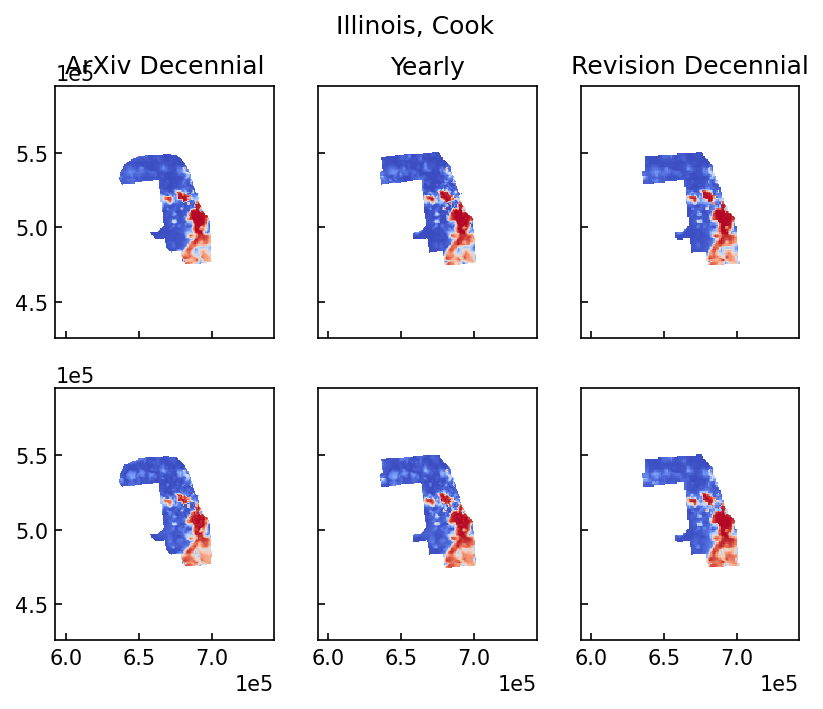

In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import scipy.interpolate as interpolate
import h5py
import matplotlib.pyplot as plt

data_dir = '/home/jcolen/data/sociohydro/decennial/revision/'

fig, ax = plt.subplots(2, 3, dpi=150, sharex=True, sharey=True)

state = 'Illinois'
county = 'Cook'

with h5py.File(f'/home/jcolen/data/sociohydro/decennial/processed/cook_IL.hdf5', 'r') as h5f:
    dx = h5f['x_grid'][1,1] - h5f['x_grid'][0,0]
    dy = h5f['y_grid'][1,1] - h5f['y_grid'][0,0]
    print(f'For grid of shape {h5f["x_grid"].shape, h5f["y_grid"].shape}, dx={dx:.3g}, dy={dy:.3g}')
    for i in range(2):
        ax[i,0].pcolormesh(h5f['x_grid'], h5f['y_grid'],
                           (h5f['w_grid_array_masked'][:,:,3+i] - h5f['b_grid_array_masked'][:,:,3+i]) / 
                           (h5f['w_grid_array_masked'][:,:,3+i] + h5f['b_grid_array_masked'][:,:,3+i]),
                           vmin=-1, vmax=1, cmap='coolwarm_r', rasterized=True)        
with h5py.File(f'/home/jcolen/data/sociohydro/yearly/processed/{state}_{county}.hdf5', 'r') as h5f:
    for i, year in enumerate(['2010', '2020']):
        g = h5f[year]
        if i == 0:
            dx = g['x_grid'][1,1] - g['x_grid'][0,0]
            dy = g['y_grid'][1,1] - g['y_grid'][0,0]
            print(f'For grid of shape {g["x_grid"].shape, g["y_grid"].shape}, dx={dx:.3g}, dy={dy:.3g}')
        ax[i,1].pcolormesh(g['x_grid'], g['y_grid'], 
                           (g['w_grid_masked'][:] - g['b_grid_masked'][:]) / 
                           (g['w_grid_masked'][:] + g['b_grid_masked'][:]),
                           vmin=-1, vmax=1, cmap='coolwarm_r', rasterized=True)

with h5py.File(f'/home/jcolen/data/sociohydro/decennial/revision/gridded/{state}_{county}.hdf5', 'r') as h5f:
    for i, year in enumerate(['2010', '2020']):
        g = h5f[year]
        if i == 0:
            dx = g['x_grid'][1,1] - g['x_grid'][0,0]
            dy = g['y_grid'][1,1] - g['y_grid'][0,0]
            print(f'For grid of shape {g["x_grid"].shape, g["y_grid"].shape}, dx={dx:.3g}, dy={dy:.3g}')
        ax[i,2].pcolormesh(g['x_grid'], g['y_grid'], 
                           (g['white_grid_county'][:] - g['black_grid_county'][:]) / 
                           (g['white_grid_county'][:] + g['black_grid_county'][:]),
                           vmin=-1, vmax=1, cmap='coolwarm_r', rasterized=True)
        
for a in ax.ravel():
    a.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
    a.tick_params(which='both', direction='in')
ax[0,0].set_title('ArXiv Decennial')
ax[0,1].set_title('Yearly')
ax[0,2].set_title('Revision Decennial')
fig.suptitle(f"{state}, {county}")

Text(0, 0.33, '2020 Census')

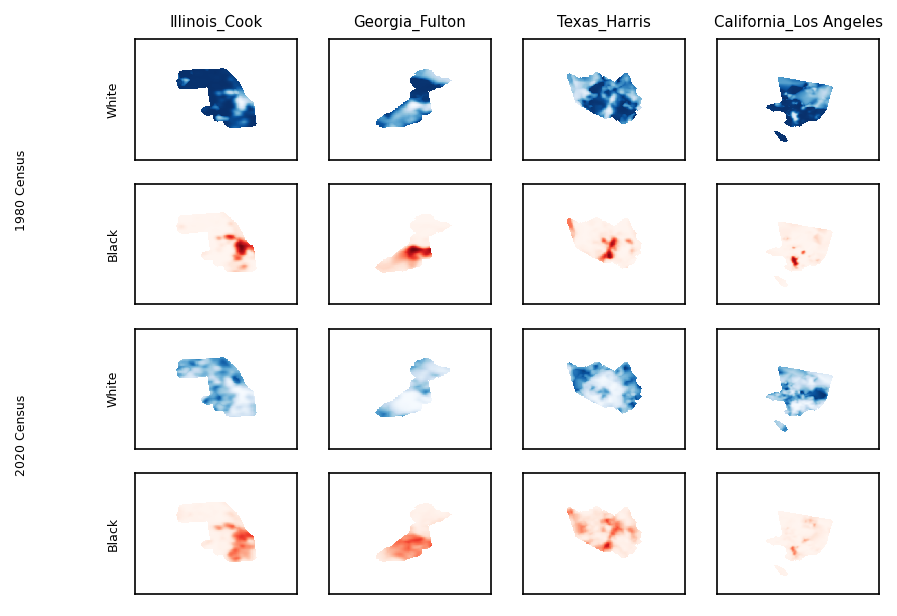

In [4]:
from census_dataset import CensusDataset
from torch.utils.data import ConcatDataset

plt.rcParams['font.size'] = 6

def plot(ax, sample, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
        
dataset = ConcatDataset([
    CensusDataset('Illinois_Cook'),
    CensusDataset('Georgia_Fulton'),
    CensusDataset('Texas_Harris'),
    CensusDataset('California_Los Angeles'),
])
fig, ax = plt.subplots(4, 4, dpi=150, sharex='col', sharey='col')
for i, ds in enumerate(dataset.datasets):
    ds.validate()
    sample = dataset[i*40]
    ax[0,i].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmin=0, vmax=1)
    ax[1,i].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmin=0, vmax=1)

    sample = dataset[i*40+39]
    ax[2,i].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmin=0, vmax=1)
    ax[3,i].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmin=0, vmax=1)

    ax[0,i].set_title(dataset.datasets[i].county)

for a in ax.flatten():
    a.set(xticks=[], yticks=[])
    
ax[0,0].set_ylabel(f'White')
ax[1,0].set_ylabel(f'Black')
ax[2,0].set_ylabel(f'White')
ax[3,0].set_ylabel(f'Black')

fig.text(0, 0.67, '1980 Census', rotation=90, va='center', ha='left')
fig.text(0, 0.33, '2020 Census', rotation=90, va='center', ha='left')

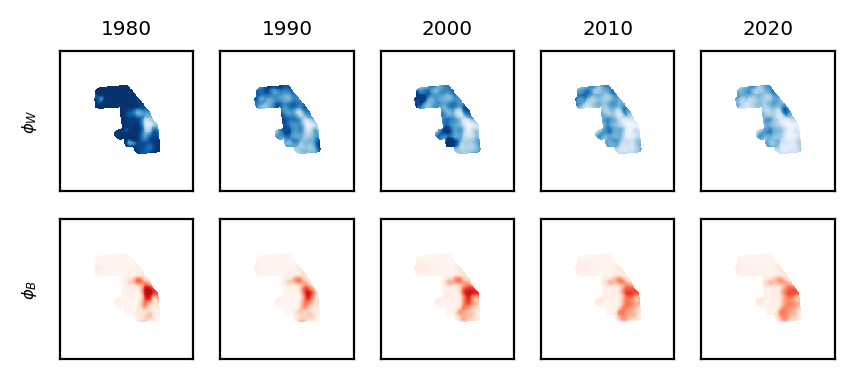

In [6]:
dataset = CensusDataset('Illinois_Cook')
dataset.validate()

fig, ax = plt.subplots(2, 5, figsize=(5, 2), dpi=200)

for i in range(5):
    wb0 = dataset.wb(1980+i*10)
    ax[0,i].set_title(1980+i*10)
    ax[0,i].pcolormesh(dataset.x, dataset.y, wb0[0], vmin=0, vmax=1, cmap='Blues')
    ax[1,i].pcolormesh(dataset.x, dataset.y, wb0[1], vmin=0, vmax=1, cmap='Reds')

    
ax[0,0].set_ylabel('$\phi_W$')
ax[1,0].set_ylabel('$\phi_B$')

for a in ax.flatten():
    a.set(xticks=[], yticks=[])

(439,) (439,) (439,)
43942 0 0
nan


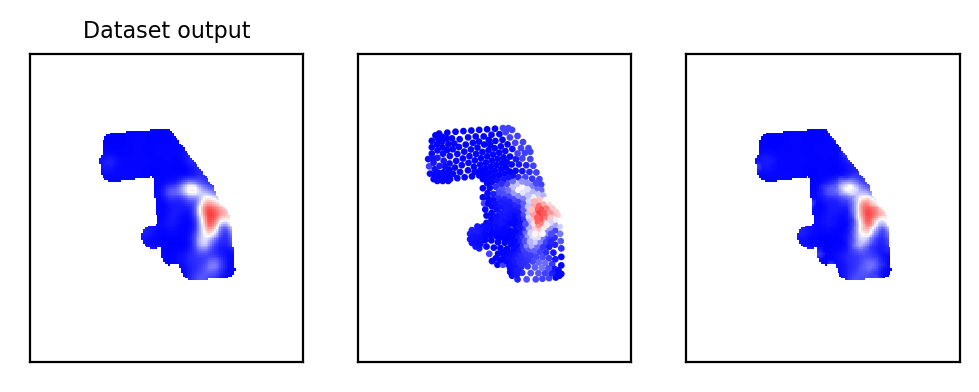

In [84]:
from dolfin_problems import mesh_to_scalar_img, scalar_img_to_mesh

dataset = CensusDataset('Illinois_Cook')
dataset.validate()

fig, ax = plt.subplots(1, 3, figsize=(6, 2), dpi=200, sharex=True, sharey=True)

sample = dataset[0]

wb0 = sample['wb0']
problem = sample['problem']
x = sample['x']
y = sample['y']
mask = sample['mask']
FctSpace = problem.FctSpace

ax[0].pcolormesh(x, y, (wb0[0]-wb0[1])/(wb0[0]+wb0[1]), cmap='bwr_r', vmin=-1, vmax=1)
ax[0].set_title('Dataset output')

wb1, wb2 = [], []
for i in range(2):
    problem.wb0[i].assign(scalar_img_to_mesh(wb0[i], x, y, FctSpace))
    wb1.append(problem.wb0[i].compute_vertex_values())
    wb2.append(mesh_to_scalar_img(problem.wb0[i], dataset.mesh, x, y, mask))
wb1 = np.stack(wb1)
wb2 = np.stack(wb2)

xv = dataset.mesh.coordinates()[:,0]
yv = dataset.mesh.coordinates()[:,1]
print(xv.shape, yv.shape, wb1[0].shape)
ax[1].scatter(xv,yv, c=(wb1[0]-wb1[1])/(wb1[0]+wb1[1]), cmap='bwr_r', vmin=-1, vmax=1, s=2)

ax[2].pcolormesh(x, y, (wb2[0]-wb2[1])/(wb2[0]+wb2[1]), cmap='bwr_r', vmin=-1, vmax=1)
mask = np.any(np.isnan(wb2), axis=0)
ax[2].scatter(x[mask], y[mask], color='black', s=2)

print(np.sum(np.isnan(wb0.numpy())), np.sum(np.isnan(wb1)), np.sum(np.isnan(wb2)))
print(np.mean(np.power(wb2 - wb0.numpy(), 2).sum(0)))

for a in ax.flatten():
    a.set(xticks=[], yticks=[])

# Neural network predictions

In [3]:
from census_dataset import CensusDataset
from scipy.interpolate import interp1d
import dolfin_adjoint as d_ad

def make_predictions_plot(model, county):
    dataset = CensusDataset(county).validate()
    wb1980 = dataset.wb(1980)
    wb2020 = dataset.wb(2020)

    # Neural network prediction
    ic = dataset[0]
    ic['wb0'] = ic['wb0'].to(device)

    with torch.no_grad(), d_ad.stop_annotating():
        wbNN = model.simulate(ic, dataset.mesh, device, tmax=40, dt=1).cpu().numpy()

    # Spline extrapolation
    spline = interp1d([1980, 1990], np.stack([dataset.wb(1980), dataset.wb(1990)]), axis=0, fill_value='extrapolate')
    wbSpline = spline(2020)

    # Error rates
    mse_NN = np.mean(np.power(wbNN - wb2020, 2).sum(0)[dataset.mask])
    mse_Sp = np.mean(np.power(wbSpline - wb2020, 2).sum(0)[dataset.mask])
    mse_No = np.mean(np.power(wb1980 - wb2020, 2).sum(0)[dataset.mask])

    print(f'For county = {county}')
    print(f'---------------------------------')
    print(f'\tModel\t\t|   MSE  ')
    print(f'---------------------------------')
    print(f'Neural Network\t\t|  {mse_NN:.3f}')
    print(f'Spline extrapolation\t|  {mse_Sp:.3f}')
    print(f'No dynamics\t\t|  {mse_No:.3f}')

    def plot(column, dataset, wb):
        prop = (wb[0] - wb[1]) / wb.sum(0)
        pc0 = column[0].pcolormesh(dataset.x, dataset.y, prop, vmin=-1, vmax=1, cmap='bwr_r')
        pc1 = column[1].pcolormesh(dataset.x, dataset.y,  wb[0], vmin=0, vmax=1, cmap='Blues')
        pc2 = column[2].pcolormesh(dataset.x, dataset.y,  wb[1], vmin=0, vmax=1, cmap='Reds')
        return pc0, pc1, pc2

    fig, ax = plt.subplots(3, 4, dpi=200)

    plot(ax[:,0], dataset, wb1980)
    plot(ax[:,1], dataset, wb2020)
    plot(ax[:,2], dataset, wbNN)
    pc0, pc1, pc2 = plot(ax[:,3], dataset, wbSpline)

    plt.rcParams['font.size'] = 8
    plt.rcParams['axes.titlesize'] = 8

    fig.colorbar(pc0, ax=ax[0,:], ticks=[-1,1]).set_ticklabels(['All\nblack', 'All\nwhite'], 
        rotation=90, verticalalignment='center', multialignment='center')
    fig.colorbar(pc1, ax=ax[1,:], ticks=[0,1], label='Fraction')
    fig.colorbar(pc2, ax=ax[2,:], ticks=[0,1], label='Fraction')

    ax[0,0].set_title('1980\ncensus data')
    ax[0,1].set_title('2020\ncensus data')
    ax[0,2].set_title('2020\nNN prediction')
    ax[0,3].set_title('2020\nSpline extrapolation')

    ax[0,0].set_ylabel('Resident\nproportion')
    ax[1,0].set_ylabel('White\noccupation')
    ax[2,0].set_ylabel('Black\noccupation')

    for a in ax.flatten():
        a.set(xticks=[], yticks=[], aspect='equal')

    return fig

In [9]:
import os
import glob
import json
import pandas as pd
import torch

def report_model(path):
    info = torch.load(path, map_location='cpu')
    with open(f'{path[:-5]}_args.txt', 'r') as f:
        params = json.load(f)
    ret = {
        'path': path,
        'val_loss': np.min(info['val_loss']),
        'train_loss': np.mean(info['train_loss'][-100:]),
        'epoch': np.argmin(info['val_loss']),
        'val_tmax': params.get('val_tmax', 40),
        'num_train_counties': params.get('num_train_counties', 0)
    }
    return ret

records = []
for path in glob.glob('models/*.ckpt'):
    records.append(report_model(path))

df = pd.DataFrame.from_records(records, np.arange(len(records)))
df.sort_values('val_loss')

,path,val_loss,train_loss,epoch,val_tmax,num_train_counties
2,models/CensusPBNN_legacy.ckpt,0.075514,0.000161,197,40,0
5,models/CensusPBNN_3055420_7.ckpt,0.274055,0.000130,41,10,8
4,models/CensusPBNN_3053489_3.ckpt,0.278351,0.000120,87,10,8
1,models/CensusPBNN_3053489_1.ckpt,0.286566,0.000135,64,10,8
9,models/CensusPBNN_3053489_0.ckpt,0.292657,0.000172,90,10,8
3,models/CensusPBNN_3055420_4.ckpt,0.293441,0.000219,87,10,8
6,models/CensusPBNN__all_counties.ckpt,0.354911,0.000129,37,10,8
8,models/CensusPBNN_3053489_2.ckpt,0.361668,0.000120,87,10,8
7,models/CensusPBNN_3055420_5.ckpt,0.375212,0.000180,28,10,8
0,models/CensusPBNN_3055420_6.ckpt,0.407416,0.000167,52,10,8


Reached minimium loss of 0.274 at epoch 41
For county = Georgia_Fulton
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.060
Spline extrapolation	|  0.644
No dynamics		|  0.262
For county = Illinois_Cook
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.027
Spline extrapolation	|  0.597
No dynamics		|  0.304
For county = Texas_Harris
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.118
Spline extrapolation	|  0.631
No dynamics		|  0.256
For county = California_Los Angeles
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.068
Spline extrapolation	|  1.539
No dynamics		|  0.245


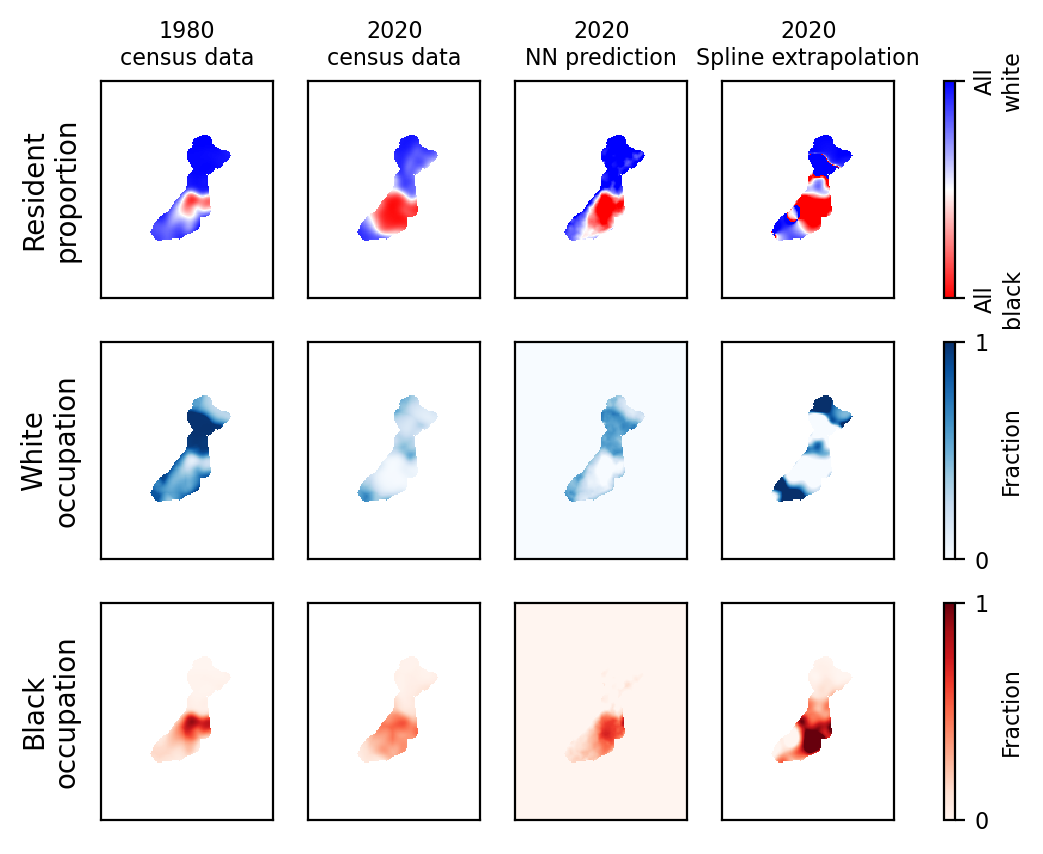

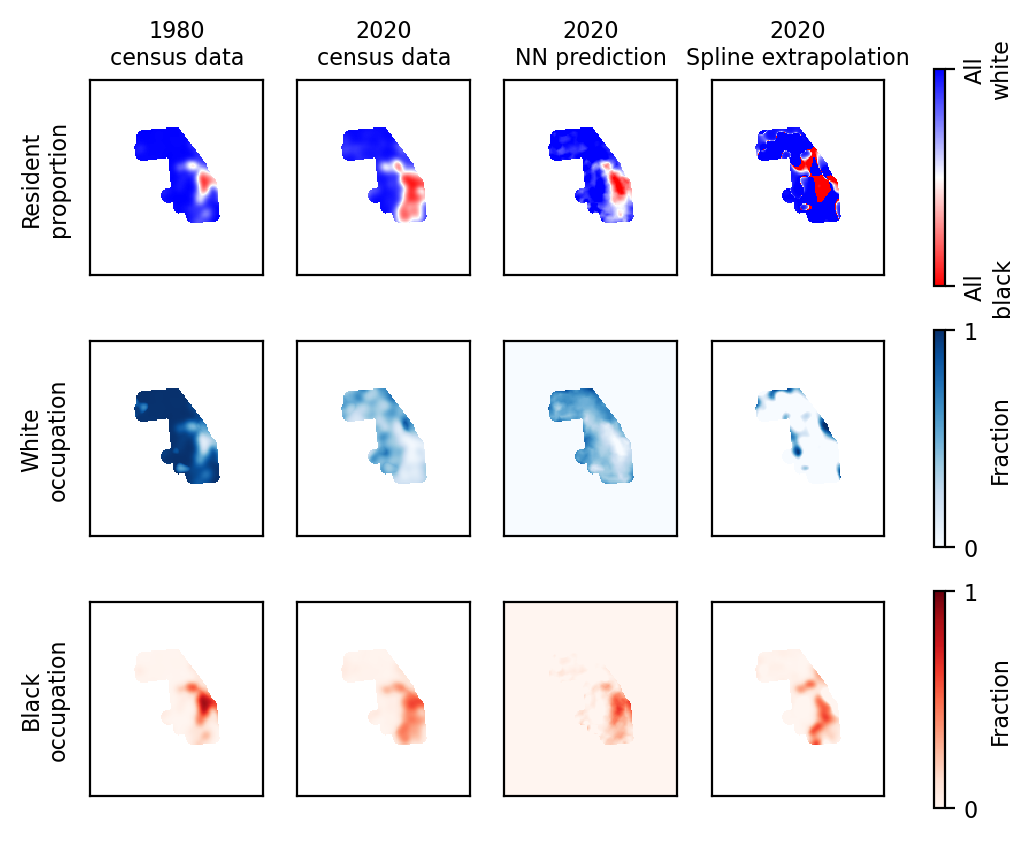

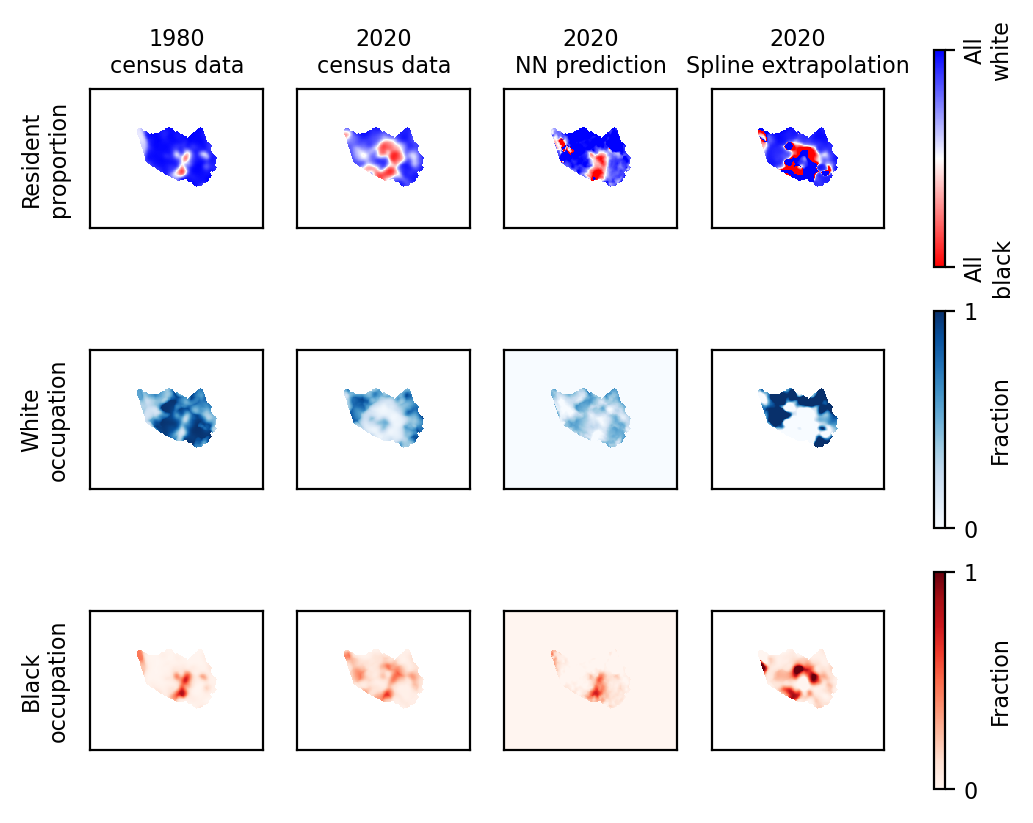

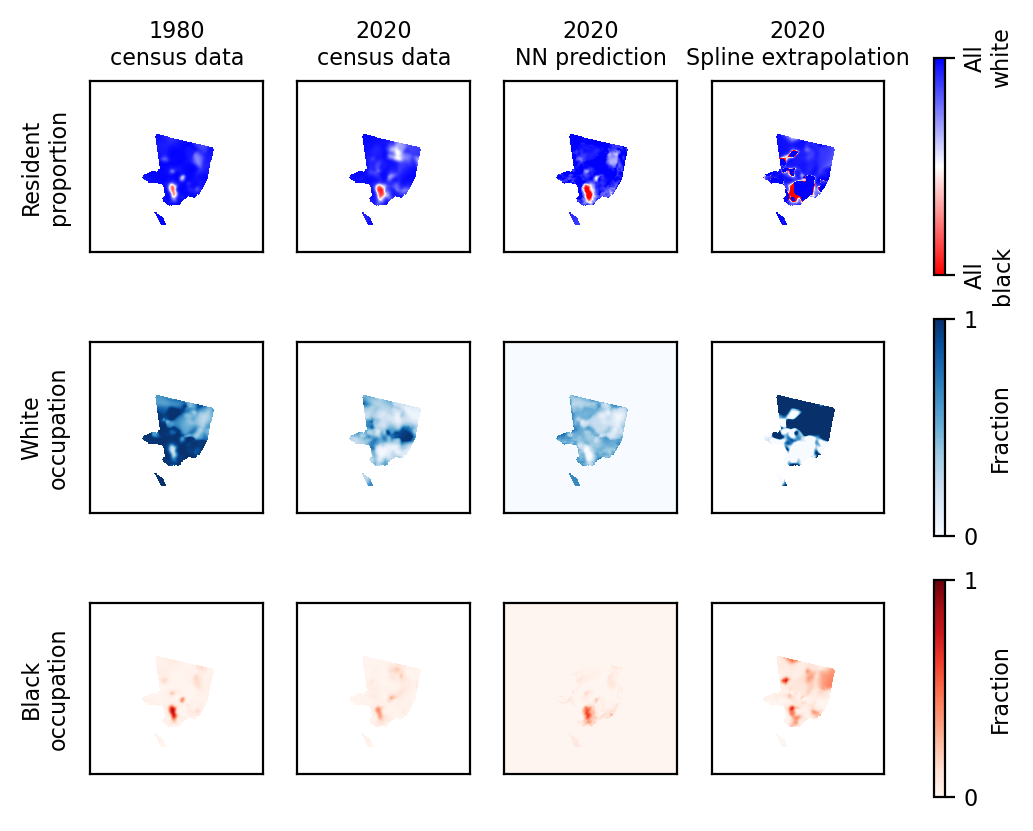

In [5]:
from census_pbnn import CensusPBNN

info = torch.load('models/CensusPBNN_3053489_3.ckpt')
info = torch.load('models/CensusPBNN_3055420_7.ckpt')
print('Reached minimium loss of', np.round(np.min(info['val_loss']), 3), 'at epoch', np.argmin(info['val_loss']), flush=True)

model = CensusPBNN().to(device)
model.eval()
model.load_state_dict(info['state_dict'], strict=False)

make_predictions_plot(model, 'Georgia_Fulton');
make_predictions_plot(model, 'Illinois_Cook');
make_predictions_plot(model, 'Texas_Harris');
make_predictions_plot(model, 'California_Los Angeles');

For county = Georgia_Fulton
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.035
Spline extrapolation	|  0.644
No dynamics		|  0.262
For county = Illinois_Cook
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.024
Spline extrapolation	|  0.597
No dynamics		|  0.304
For county = Texas_Harris
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.142
Spline extrapolation	|  0.631
No dynamics		|  0.256
For county = California_Los Angeles
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.066
Spline extrapolation	|  1.539
No dynamics		|  0.245


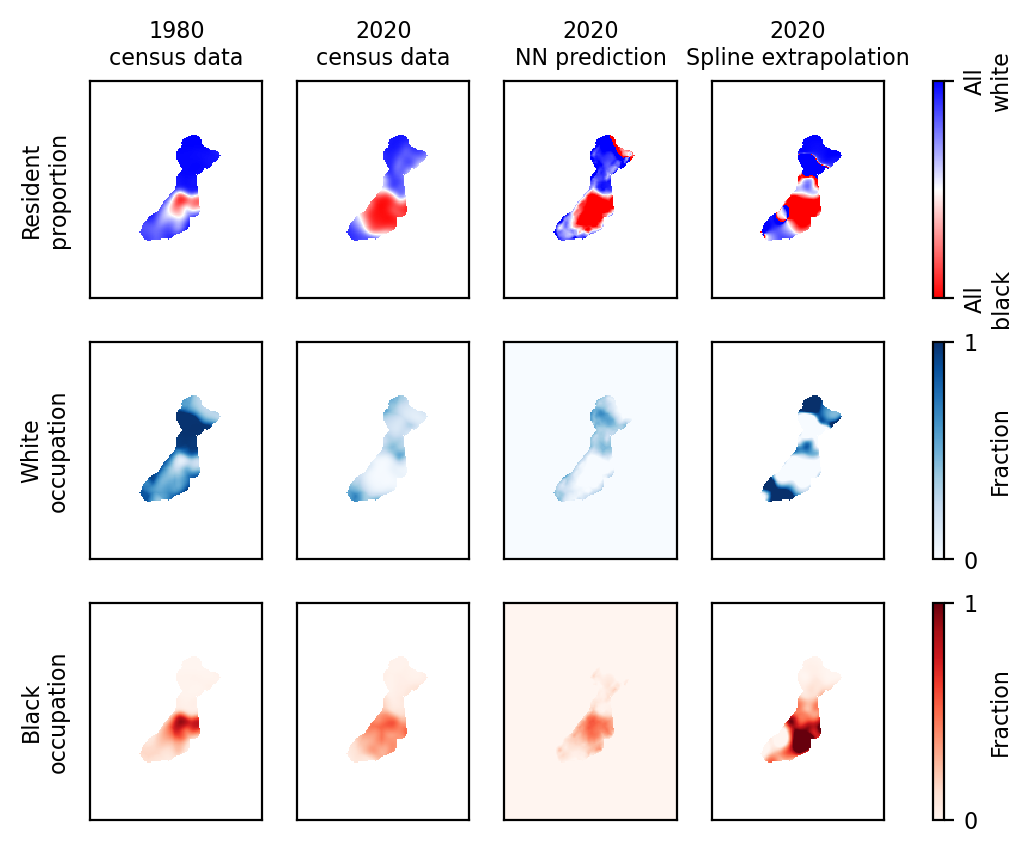

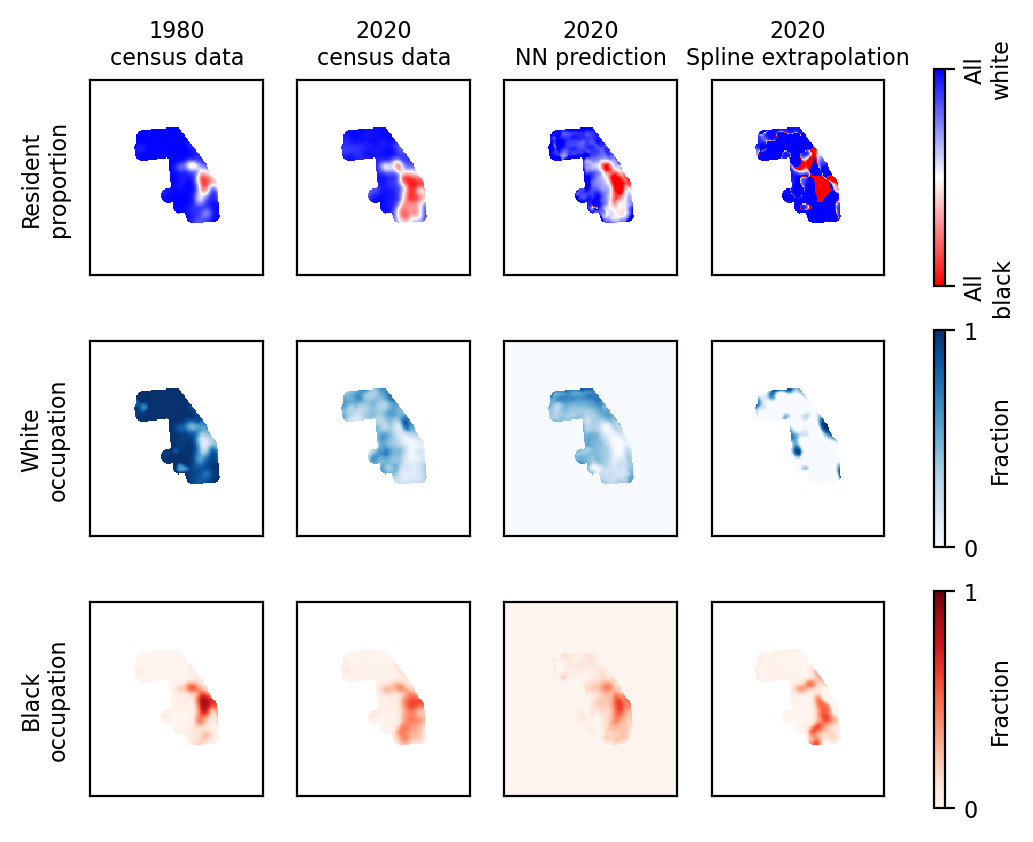

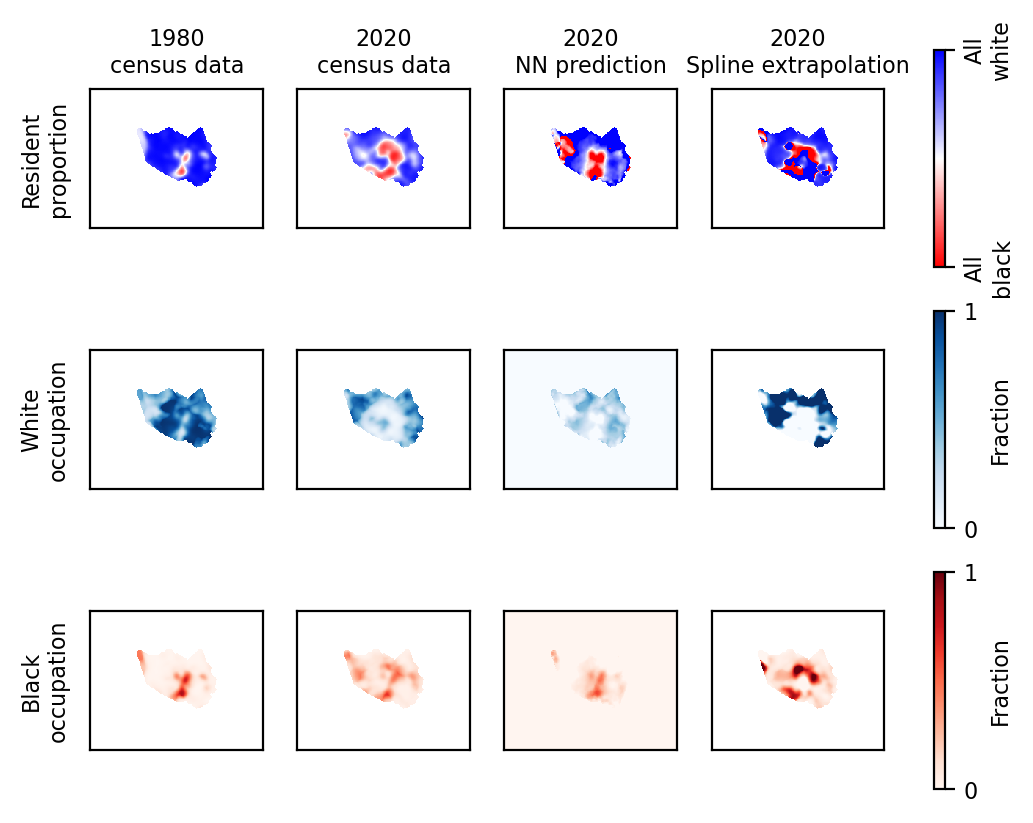

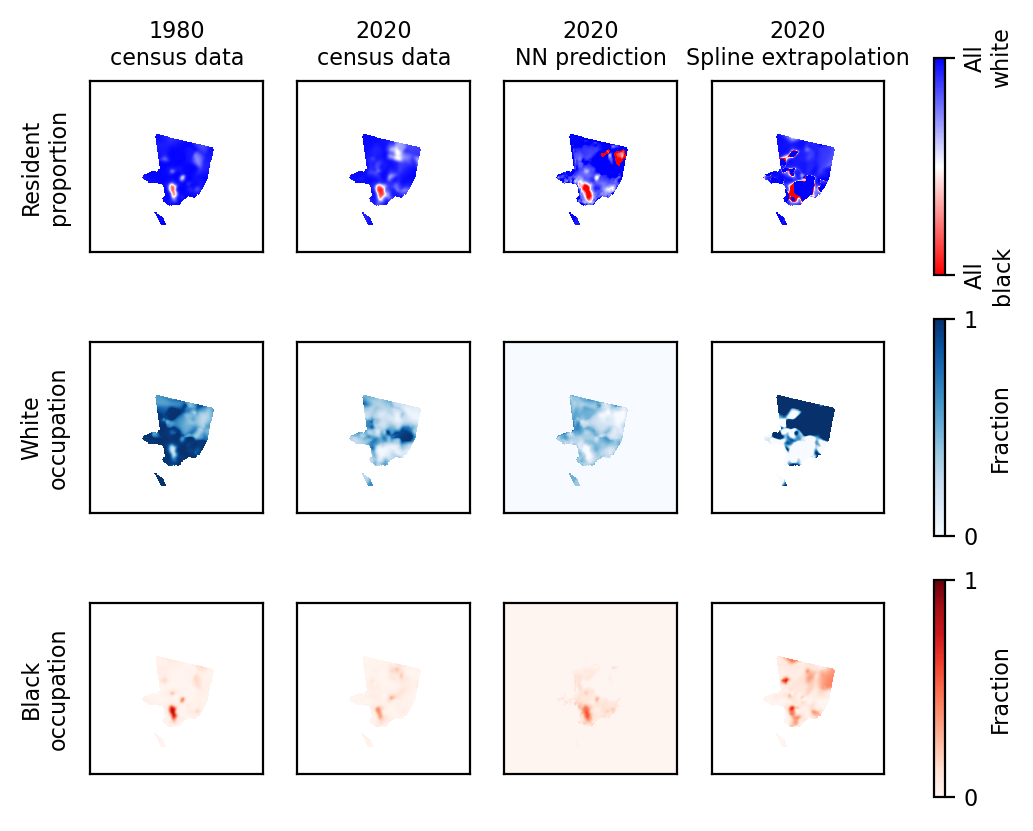

In [12]:
from census_pbnn import CensusPBNN

info = torch.load('models/CensusPBNN_legacy.ckpt')
model = CensusPBNN().to(device)
model.eval()
model.load_state_dict(info['state_dict'], strict=False)

make_predictions_plot(model, 'Georgia_Fulton');
make_predictions_plot(model, 'Illinois_Cook');
make_predictions_plot(model, 'Texas_Harris');
make_predictions_plot(model, 'California_Los Angeles');

# Build a spatial saliency map

This is now done in the training scripts

In [8]:
dataset = ConcatDataset([
    CensusDataset('cook_IL',housing_method=housing_method),
    CensusDataset('fulton_GA',housing_method=housing_method),
    CensusDataset('harris_TX',housing_method=housing_method),
    CensusDataset('la_CA',housing_method=housing_method),
])

info = torch.load(f'models/decennial/SourcedOnlyPBNN.ckpt')

model = DecennialPBNN().to(device)
model.load_state_dict(info['state_dict'], strict=False)
model.train()

for ds in dataset.datasets:
    print(dataset)
    compute_saliency(model, ds, device, 'models/decennial/SourcedOnlyPBNN')

Building dataset with constant housing in time
Building dataset with constant housing in time
Building dataset with constant housing in time
Building dataset with constant housing in time


100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


100%|██████████| 40/40 [01:20<00:00,  2.01s/it]


100%|██████████| 40/40 [01:49<00:00,  2.74s/it]


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
